In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from data_utils import *
from model_utils import *
import gpytorch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data

/tmp/ipykernel_1302832/840284867.py:33: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


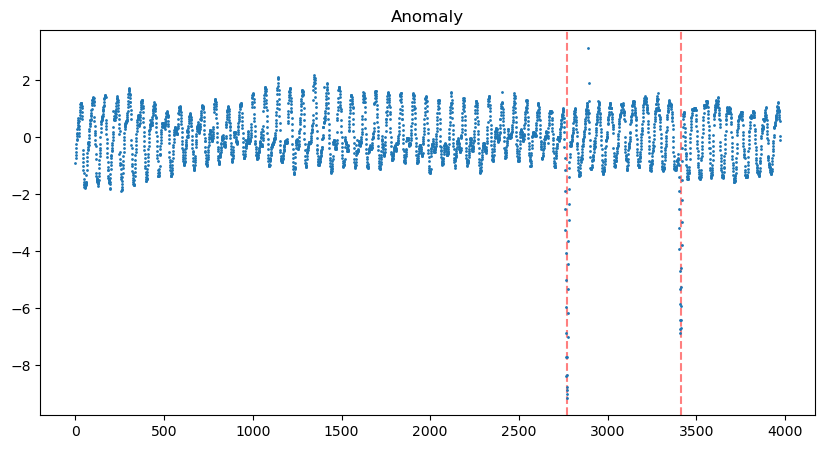

Anomaly locations:
[3411.2095358079223, 2770.6431794528526]
75.17708333333334
60.697916666666664


In [6]:
# Load a file and inject an anomaly
data_dir = '../data/k2/'
filename = 'k2_3.fits'
fits_file = fits.open(data_dir + filename)

# Load data
data = fits_file[1].data
time = np.array(data['TIME'])
pdc_flux = np.array(data['PDCSAP_FLUX'])
pdc_err = np.array(data['PDCSAP_FLUX_ERR'])

# Set x, y, and error
x = time
y = pdc_flux / np.nanmedian(pdc_flux)
y_err = pdc_err / np.nanmedian(pdc_flux)

# Clean
clean = (y_err > 0.)
x = x[clean]
y = y[clean]
y_err = np.abs(y_err[clean]) 

# Shift to start at time 0
x = x - np.min(x) 

# Bin to 30-minute cadence
num_bins = int(np.floor((np.max(x) - np.min(x)) * 48) + 1) # 48 bins per day
x_bins = np.min(x) + np.arange(num_bins + 1) / 48.
num_binned, bin_edges = np.histogram(x, bins= x_bins)
num_binned = np.array(num_binned)
y_binned, bin_edges = np.histogram(x, bins = x_bins, weights = y)
var_binned, bin_edges = np.histogram(x, bins = x_bins, weights= 1 / y_err**2)
y_err_binned = 1 / np.sqrt(np.array(var_binned))
y_binned = np.array(y_binned)
y_binned = y_binned / (num_binned + 0.001)
x_binned = x_bins[0:num_bins] + (x_bins[1] - x_bins[0]) / 2. 
x = x_binned
y = y_binned
y_err = y_err_binned

# Clean
clean = ((y > 0.) & ~np.isnan(y_err))
x = x[clean]
y = y[clean]
y_err = y_err[clean]

assert len(x) == len(y) == len(y_err), 'Lengths of x, y, and y_err must be the same'

# Inject anomalies
steps, y, anomaly_locs = inject_anomaly(y, num_anomalies=2, seed=42)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Create original copies of x and y
x_orig = np.copy(x)
y_orig = np.copy(y)
y_err_orig = np.copy(y_err)

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
y_err_tensor = torch.tensor(y_err, dtype=torch.float32).to(device)

# Plot
plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title("Anomaly")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

# Anomaly detection with GP
### Method:
1. Perform GP regression on the timeseries.
2. Find the most significant outlier point.
3. Exclude that point and redo regression. See if GP improves by some threshold.
4. Exclude adjacent points and redo step 3.
5. Repeat step 4 as long as GP improves the fit by some threshold.
6. If no improvement, define anomaly signal as the difference between data and regression in that interval of points.
7. Repeat steps 2-6 for a defined number of anomalies.

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(




 New dip identified at anomalous index 2770, x[index] = 60.697916666666664
Old metric: 1000000.0 - New metric: 0.9569604992866516 = Diff metric: 999999.0625
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 2768:2772
Old metric: 0.9569604992866516 - New metric: 0.9424917697906494 = Diff metric: 0.014468729496002197
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 2766:2774
Old metric: 0.9424917697906494 - New metric: 0.9305497407913208 = Diff metric: 0.011942028999328613
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 2764:2776
Old metric: 0.9305497407913208 - New metric: 0.9229145050048828 = Diff metric: 0.007635235786437988
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 2762:2778
Old metric: 0.9229145050048828 - New metric: 0.9160715341567993 = Diff metric: 0.006842970848083496
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 2760:2780
Old metric: 0.9160715341567993 - New metric: 0.9172491431236267 = Diff 

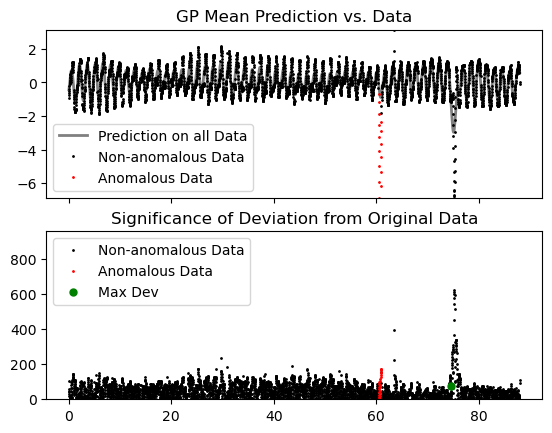



 New dip identified at anomalous index 3387, x[index] = 74.63541666666667
Old metric: 1000000.0 - New metric: 0.9159628748893738 = Diff metric: 999999.0625
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3385:3389
Old metric: 0.9159628748893738 - New metric: 0.9157864451408386 = Diff metric: 0.00017642974853515625
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3383:3391
Old metric: 0.9157864451408386 - New metric: 0.9140934944152832 = Diff metric: 0.00169295072555542
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3381:3393
Old metric: 0.9140934944152832 - New metric: 0.9106417894363403 = Diff metric: 0.003451704978942871
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3379:3395
Old metric: 0.9106417894363403 - New metric: 0.9096270799636841 = Diff metric: 0.00101470947265625
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 3377:3397
Old metric: 0.9096270799636841 - New metric: 0.9061060547828674 = Diff metric: 0.0035210251808166504
Anomaly index 1 x[i] 0.03125, left_e

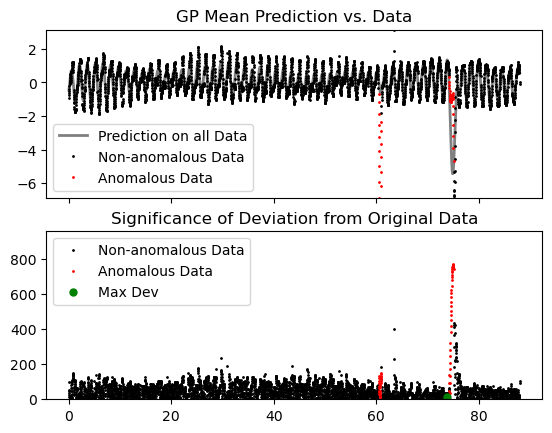



 New dip identified at anomalous index 3348, x[index] = 73.78125
Old metric: 1000000.0 - New metric: 0.892198383808136 = Diff metric: 999999.125
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3346:3350
Old metric: 0.892198383808136 - New metric: 0.8915718197822571 = Diff metric: 0.0006265640258789062
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3344:3352
Old metric: 0.8915718197822571 - New metric: 0.8926215767860413 = Diff metric: -0.0010497570037841797
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 3342:3354


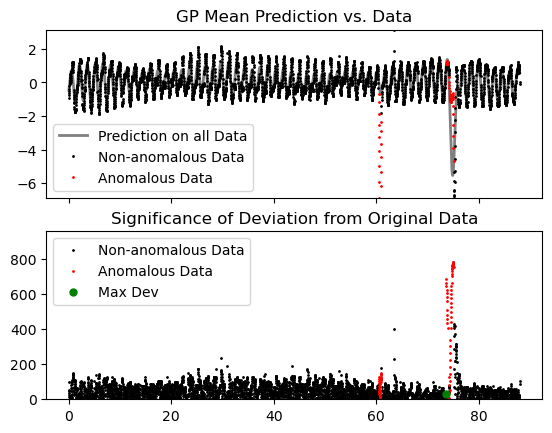



 New dip identified at anomalous index 3336, x[index] = 73.51041666666667
Old metric: 1000000.0 - New metric: 0.8918733596801758 = Diff metric: 999999.125
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 3334:3338
Old metric: 0.8918733596801758 - New metric: 0.8922234773635864 = Diff metric: -0.00035011768341064453
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 3332:3340


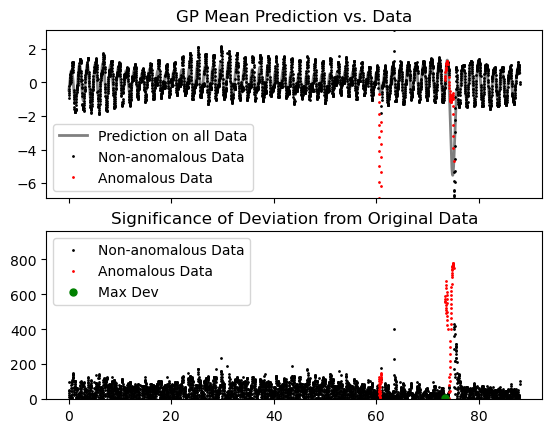

In [7]:
# Hyperparameters
which_metric = 'msll' # 'rmse', 'nlpd', msll, or default is 'mll'
num_anomalies = 4
num_steps = len(x)
anomalous = np.zeros(num_steps) # 0 means non-anomalous, 1 means anomalous at that time step
initial_lengthscale = None #0.3**2
expansion_param = 2 # how many indices left and right to increase anomaly by

# Train GP model
model, likelihood, mll = train_gp(x_tensor, y_tensor, y_err_tensor, training_iterations=30, lengthscale=initial_lengthscale, device=device)
final_lengthscale = model.covar_module.base_kernel.lengthscale.item()

# Step 7 (repeat for every anomaly)
for i in range(num_anomalies):
    # Get subset of data that is flagged an non-anomalous
    x_sub = torch.tensor(x[anomalous == 0], dtype=torch.float32).to(device)
    y_sub = torch.tensor(y[anomalous == 0], dtype=torch.float32).to(device)
    y_err_sub = torch.tensor(y_err[anomalous == 0], dtype=torch.float32).to(device)

    # Re-fit the GP on non-anomalous data
    model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Find index of largest deviation
    sig_dev = (pred_mean - y) / y_err
    index = np.argmax(sig_dev[anomalous == 0])
    print(f"\n\n New dip identified at anomalous index {index}, x[index] = {x[index]}")

    # Intialize variables for expanding anomalous region
    left_edge = index
    right_edge = index
    diff_metric = 1e6
    metric = 1e6
    
    # While the metric is decreasing, expand the anomalous edges
    while diff_metric > 0:
        # Subset x, y, and y_err
        subset = (((np.arange(len(x)) > right_edge) | (np.arange(len(x)) < left_edge)) & (anomalous == 0))
        x_sub = torch.tensor(x[subset], dtype=torch.float32).to(device)
        y_sub = torch.tensor(y[subset], dtype=torch.float32).to(device)
        y_err_sub = torch.tensor(y_err[subset], dtype=torch.float32).to(device)
        
        # Re-fit the GP on non-anomalous data
        model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

        # Predict on subset
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(x_sub))
            pred_mean = observed_pred.mean.cpu().numpy()
            pred_var = observed_pred.variance.cpu().numpy()

        # Calculate metric difference
        old_metric = metric

        if which_metric == 'nlpd':
            metric = gpytorch.metrics.negative_log_predictive_density(observed_pred, y_sub)
        elif which_metric == 'msll':
            metric = gpytorch.metrics.mean_standardized_log_loss(observed_pred, y_sub)
        elif which_metric == 'rmse':
            metric = np.sqrt(np.mean((pred_mean - y_sub.cpu().numpy())**2))
        else: # metric == mll
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                output = model(x_sub)
                metric = mll(output, y_sub)

        diff_metric = old_metric - metric # smaller is better
        print(f"Old metric: {old_metric} - New metric: {metric} = Diff metric: {diff_metric}")

        # Expand anomalous region on both sides
        if left_edge >= 0 + expansion_param:
            left_edge -= expansion_param
        if right_edge < len(x) - expansion_param:
            right_edge += expansion_param

        print(f"Anomaly index {i} x[i] {x[i]}, left_edge:right_edge {left_edge}:{right_edge}")

    # Update anomalous array
    y[left_edge:right_edge] = pred_mean[left_edge:right_edge]
    anomalous[left_edge:right_edge] = 1

    # Predict on full dataset
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Plot
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].set_title("GP Mean Prediction vs. Data")
    axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
    axs[0].plot(x[(anomalous==0)], y_orig[(anomalous==0)], '.k', markersize=2, label="Non-anomalous Data")
    axs[0].plot(x[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Anomalous Data")
    axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
    axs[0].legend()

    sig_dev = (pred_mean - y) / y_err
    axs[1].set_title("Significance of Deviation from Original Data")
    axs[1].plot(x[(anomalous==0)], np.abs(sig_dev[(anomalous==0)]), '.k', markersize=2, label="Non-anomalous Data")
    axs[1].plot(x[(anomalous==1)], np.abs(sig_dev[(anomalous==1)]), '.r', markersize=2, label="Anomalous Data")
    axs[1].plot(x[np.argmax(sig_dev[(anomalous==0)])], np.abs(sig_dev[np.argmax(sig_dev[(anomalous==0)])]), '.g', markersize=10, label="Max Dev")
    axs[1].set_ylim(0, 20 * np.median(np.abs(sig_dev[(anomalous==0)])))
    axs[1].legend()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

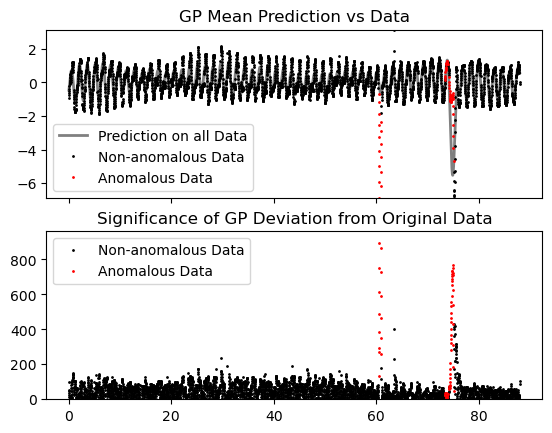

In [8]:
# Fit on final subset
model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))
    pred_mean = observed_pred.mean.cpu().numpy()
    pred_var = observed_pred.variance.cpu().numpy()

# Plot
fig, axs = plt.subplots(2,1,sharex=True)
axs[0].set_title("GP Mean Prediction vs Data")
axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Non-anomalous Data")
axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
axs[0].plot(x_orig[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Anomalous Data")
axs[0].legend()

sigdev = (pred_mean - y_orig) / y_err_orig
axs[1].set_title("Significance of GP Deviation from Original Data")
axs[1].plot(x[(anomalous==0)], np.abs(sigdev[(anomalous==0)]), '.k', markersize=2, label="Non-anomalous Data")
axs[1].plot(x[(anomalous==1)], np.abs(sigdev[(anomalous==1)]), '.r', markersize=2, label="Anomalous Data")
axs[1].set_ylim(0, 20 * np.median(np.abs(sigdev[(anomalous==0)])))
axs[1].legend()
plt.show(block=True)

In [9]:
# Check whether every anomaly_locs was identified in the anomalous array
identified = np.zeros(len(anomaly_locs))
flagged_anomalies = np.where(anomalous == 1)

for i in range(len(anomaly_locs)):
    anomaly = int(anomaly_locs[i])

    if np.isin(anomaly, flagged_anomalies):
        identified[i] = 1
    else:
        print(f"Anomaly at index {anomaly} was not identified in the anomalous array")

identified_ratio = np.sum(identified) / len(anomaly_locs)

print(f"Injected anomaly centers: {anomaly_locs}")
print(f"Anomalies identified: {identified}")
print(f"Ratio of anomalies identified: {identified_ratio}")
print(f"Flagged anomalies: {flagged_anomalies}")

Anomaly at index 3411 was not identified in the anomalous array
Injected anomaly centers: [3411.2095358079223, 2770.6431794528526]
Anomalies identified: [0. 1.]
Ratio of anomalies identified: 0.5
Flagged anomalies: (array([2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768,
       2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779,
       2780, 2781, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3342,
       3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353,
       3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377,
       3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388,
       3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399,
       3400, 3401, 3402, 3403, 3404, 3405, 3406]),)
